# Measure patch-fitted curvature

There are multiple ways to determine curvature on the surface of a mesh. The most basic and likely exact method is based on polyhedral angles and can be extracted [through vedo](https://vedo.embl.es/docs/vedo/mesh.html#Mesh.compute_curvature), for instance. Another approach is to fit spheres to every point of the mesh and extract the curvature from the radius of the sphere.

The approach described in this notebook revolves around extracting patches of neighboring pointds around each queried point in a pointcloud or a mesh, and approaximating thes shape of this patch with a 2D 2nd order polynomial. The curvature is then extracted from the coefficients of this polynomial.

In [1]:
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import vedo
from skimage import filters, measure

from napari_stress import approximation, measurements, sample_data

In [2]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.
Assistant skips harvesting pyclesperanto_prototype as it's not installed.


## Load sample data

We first load some sample data that comes with napari-stress, binarize it and extract the surface with [napari-process-points-and-surfaces](https://github.com/haesleinhuepf/napari-process-points-and-surfaces).

In [3]:
data = sample_data.get_droplet_4d()[0][0][0]
data.shape

(16, 30, 31)


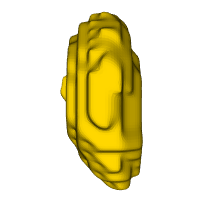

In [4]:
binary = data > filters.threshold_otsu(data)
vertices, faces, _, _ = measure.marching_cubes(binary, level=0.5)
mesh = vedo.Mesh([vertices.astype(int), faces])
mesh.clean().subdivide(2).smooth()

In [6]:
surface = list([mesh.vertices, np.asarray(mesh.cells), np.ones(mesh.nvertices)])

## Measureing curvature

We can now measure the curvature of the surface using the `calculate_patch_fitted_curvature_on_surface` from the `measurements` module. It takes a surface mesh and a radius as input. The radius determines the size of the patch that is extracted around each point. The curvature is then calculated from the coefficients of the 2nd order polynomial that is fitted to the patch.

In [7]:
curvatures = measurements.calculate_patch_fitted_curvature_on_surface(surface)
curvatures.head()

,mean_curvature,principal_curvature_1,principal_curvature_2
0,0.035063,0.134491,-0.064365
1,0.061876,0.161581,-0.037801
2,0.097009,0.195193,-0.001117
3,0.062174,0.165184,-0.040809
4,0.115886,0.210471,0.021351


## Visualize curvature

Lastly, we want to visualize curvature in napari. To do this, we need to replace the third entry of the surface tuple in napari (which consists of `(vertices, faces, values)`) - the values - with the curvature values.

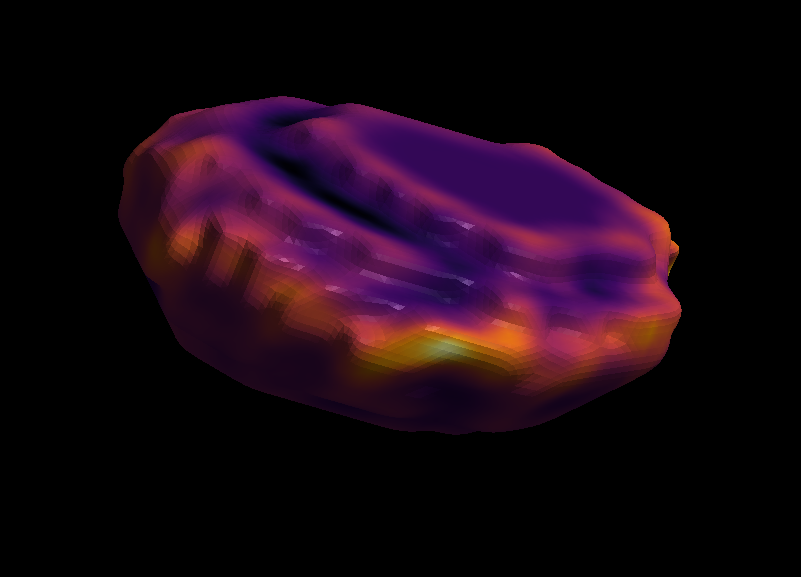

In [8]:
surface[2] = curvatures['mean_curvature']
viewer.add_surface(surface, name='surface', colormap='inferno')

viewer.camera.angles = (116, -65, -135)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Benchmark

How exact is this method? We can find out by measureing the curvature with this approach on the surface of an ellipsoid, the mean curvature of which can be derived analytically by the [following formula](https://mathworld.wolfram.com/Ellipsoid.html):

$H = \frac{a b c [3(a^2+b^2) + 2c^2 + (a^2 + b^2 -2c^2)cos(2\phi) - 2(a^2 - b^2)cos(2\theta)sin^2(\phi)]}{8[a^2b^2cos^2(\phi) + c^2(b^2 cos^2(\theta) + a^2 sin^2 (\theta)) sin^2\phi]^{3/2}}$

In [9]:
viewer.layers.clear()
ellipsoid = vedo.Ellipsoid()

expander = approximation.EllipsoidExpander()
expander.fit(ellipsoid.vertices)

curvature_on_ellipsoid = pd.DataFrame(
    measurements.curvature_on_ellipsoid(expander.coefficients_, ellipsoid.vertices)[1]['features'])

curvature_on_ellipsoid

,mean_curvature,principal_curvatures_k1,principal_curvatures_k2,frame
0,3.750001,6.000001,1.500001,0
1,3.750001,6.000001,1.500001,0
2,3.137814,4.875855,1.399774,0
3,2.103457,3.014454,1.192460,0
4,1.375106,1.754581,0.995632,0
...,...,...,...,...
1053,0.726945,0.785634,0.668256,0
1054,0.968447,1.104336,0.832559,0
1055,1.390061,1.786185,0.993937,0
1056,2.118847,3.044352,1.193342,0


Now we calculate the iterative mean curvature on the ellipsoid surface:

In [10]:
surface = [ellipsoid.vertices, np.asarray(ellipsoid.cells), np.ones(ellipsoid.nvertices)]
curvature_on_ellipsoid_fitted = measurements.calculate_patch_fitted_curvature_on_surface(surface, search_radius=0.25)

lastly, we compare compare the iterative mean curvature with the analytical mean curvature:

In [11]:
difference = curvature_on_ellipsoid_fitted['mean_curvature'] - curvature_on_ellipsoid['mean_curvature']
print('Mean difference: ', difference.mean(), '+/-', difference.std())

Mean difference:  0.21546469976553753 +/- 0.19787134509486273


We can also visualize where the values line up and where they don't:

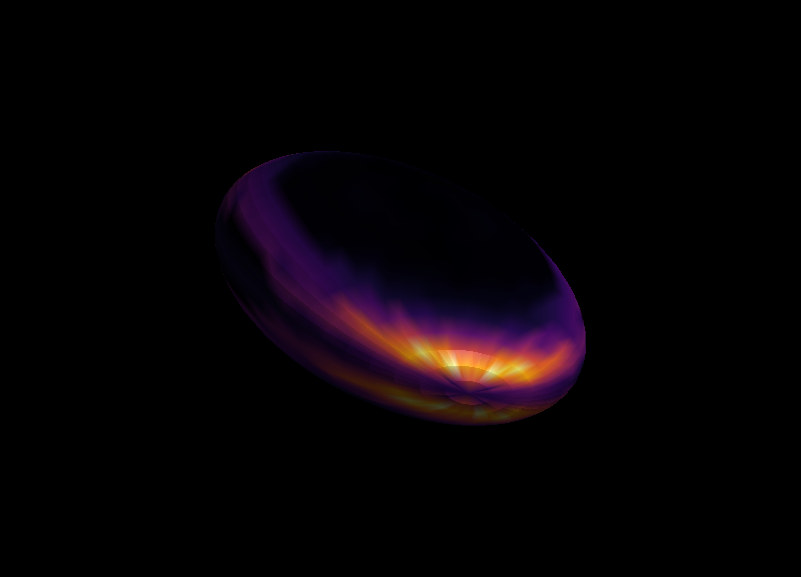

In [12]:
difference_surface = (ellipsoid.vertices, np.asarray(ellipsoid.cells), difference.values)
viewer.add_surface(difference_surface, name='difference', colormap='inferno')
viewer.camera.center = (0, 0, 0)
viewer.camera.angles = (123, -63, -136)
viewer.camera.zoom = 184

napari.utils.nbscreenshot(viewer, canvas_only=True)

## The influence of the patch radius

The results of the patch-fitted mean curvature rely strongly on the `search_radius` parameter. The larger the radius, the bigger the patch that is extracted around each point. If the radius is too small, the patch might not contain enough points to fit a 2nd order polynomial. If the radius is too large, the patch might contain points that are too far away from the queried point to be relevant for the curvature calculation. In the example above, the radius was set to 0.2.

To unravel this a bit, let's try and measure the curvature of the ellipsoid surface with different patch radii

In [13]:
radii = np.arange(0.1, 0.9, 0.05)
radii

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85])

Text(0, 0.5, 'Mean difference')

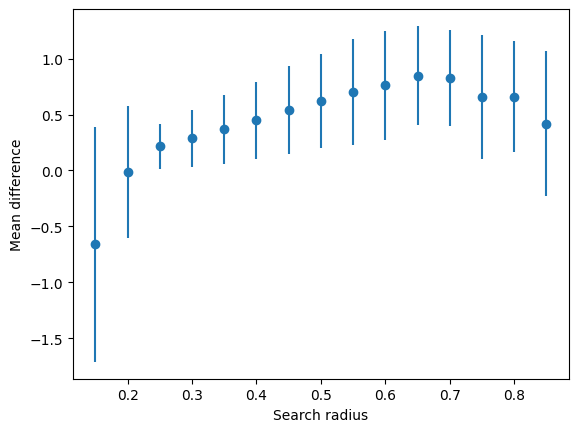

In [14]:
mean = []
std = []
for radius in radii:
    try:
        curvature_on_ellipsoid_fitted = measurements.calculate_patch_fitted_curvature_on_surface(
            surface, search_radius=radius)
        difference = curvature_on_ellipsoid_fitted['mean_curvature'] - curvature_on_ellipsoid['mean_curvature']

        mean.append(difference.mean())
        std.append(difference.std())
    except:
        mean.append(np.nan)
        std.append(np.nan)

fig, ax = plt.subplots()
ax.errorbar(radii, mean, yerr=std, fmt='o', label='mean difference between fitted and analytical curvature')
ax.set_xlabel('Search radius')
ax.set_ylabel('Mean difference')